# GLM: Linear Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import theano
import pandas as pd
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.tools.plotting import scatter_matrix

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.


Simple example
==============

Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [2]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

The `glm.linear_component()` function can be used to generate the output variable y_est and coefficients of the specified linear model.

/usr/local/var/pyenv/versions/miniconda3-4.0.5/envs/testenv/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  from ipykernel import kernelapp as app
Applied interval-transform to sigma and added transformed sigma_interval_ to model.
100%|██████████| 2000/2000 [00:02<00:00, 932.70it/s]


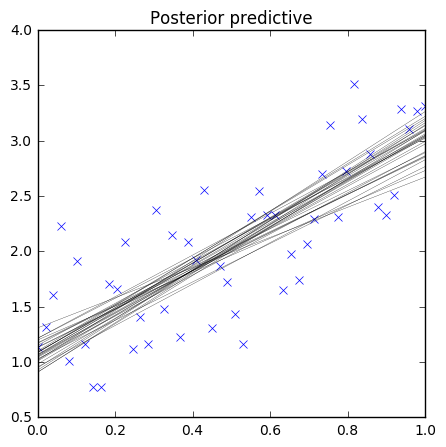

In [3]:
with Model() as model:
    y_est, coeffs = glm.linear_component('y ~ x', data)
    sigma = Uniform('sigma', 0, 20)
    y_obs = Normal('y_obs', mu=y_est, sd=sigma, observed=y)
    start = find_MAP(vars=[sigma])
    step = Slice(model.vars)
    trace = sample(2000, step, start)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
glm.plot_posterior_predictive(trace)

Since there are a couple of general linear models that are being used over and over again (Normally distributed noise, logistic regression etc), the `glm.glm()` function simplifies the above step by creating the likelihood (y_obs) and its priors (sigma) for us. Since we are working in the model context, the random variables are all added to the model behind the scenes. This function also automatically finds a good starting point which it returns.

Note that the below call to `glm()` is producing exactly the same model as above, just more succinctly.

Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:02<00:00, 887.52it/s]


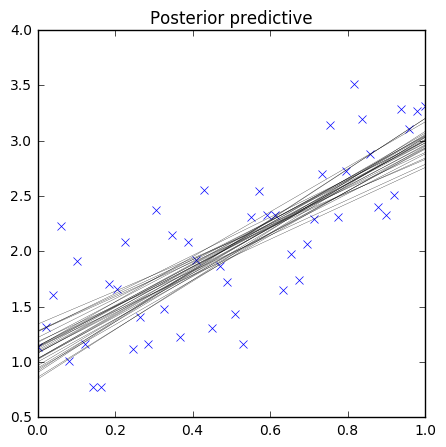

In [4]:
with Model() as model:
    glm.glm('y ~ x', data)
    trace = sample(2000, Slice(model.vars))

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
glm.plot_posterior_predictive(trace)

Robust GLM
==========

Lets try the same model but with a few outliers in the data.

In [5]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:02<00:00, 885.06it/s]


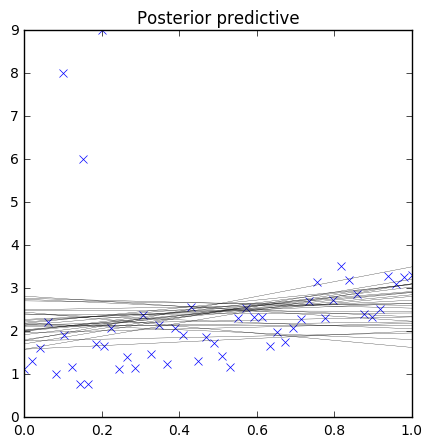

In [6]:
with Model() as model:
    glm.glm('y ~ x', data_outlier)
    trace = sample(2000, Slice(model.vars))

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
glm.plot_posterior_predictive(trace)

Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the `linear_compoment()` function and manually defining the T likelihood we can use the `glm()` function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to `y_est` (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom `nu` to 1.5.

Applied interval-transform to lam and added transformed lam_interval_ to model.
100%|██████████| 2000/2000 [00:02<00:00, 870.31it/s]


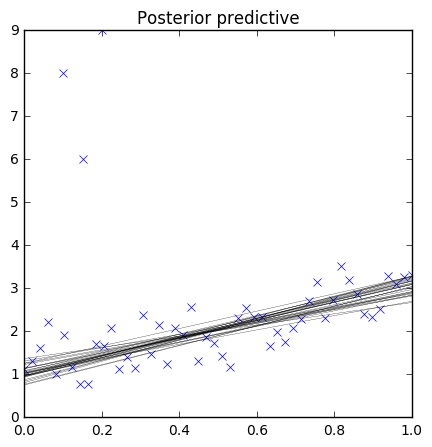

In [7]:
with Model() as model_robust:
    family = glm.families.StudentT(link=glm.families.Identity(),  
                                   priors={'nu': 1.5,
                                           'lam': Uniform.dist(0, 20)})
    glm.glm('y ~ x', data_outlier, family=family)    
    trace = sample(2000, Slice(model_robust.vars))

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
glm.plot_posterior_predictive(trace)

# Hierarchical GLM

In [8]:
sat_data = pd.read_csv('../data/Guber1999data.txt')

In [9]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_sd = Uniform('grp_sd', 0, 200)
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std()),
          'spend': Normal.dist(mu=grp_mean, sd=grp_sd),
          'stu_tea_rat': Normal.dist(mu=grp_mean, sd=grp_sd),
          'salary': Normal.dist(mu=grp_mean, sd=grp_sd),
          'prcnt_take': Normal.dist(mu=grp_mean, sd=grp_sd)
    }
    glm.glm('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data, priors=priors)
    trace_sat = sample(500, NUTS())

Applied interval-transform to grp_sd and added transformed grp_sd_interval_ to model.
Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 500/500 [04:03<00:00,  1.01s/it]


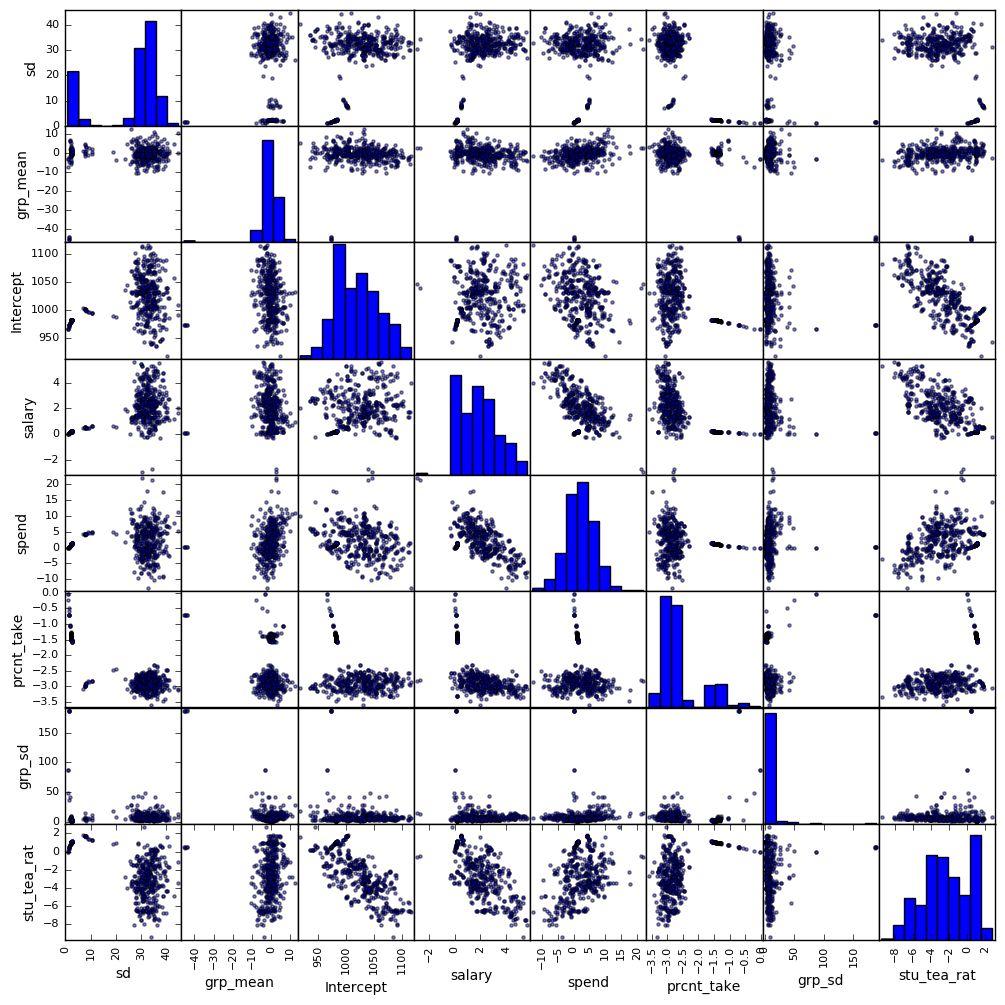

In [10]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [11]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std())
    glm.glm('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
        intercept_prior=intercept, regressor_prior=slope)
    trace_sat = sample(500, NUTS())

Applied log-transform to grp_prec and added transformed grp_prec_log_ to model.
Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 500/500 [02:14<00:00,  1.69it/s]


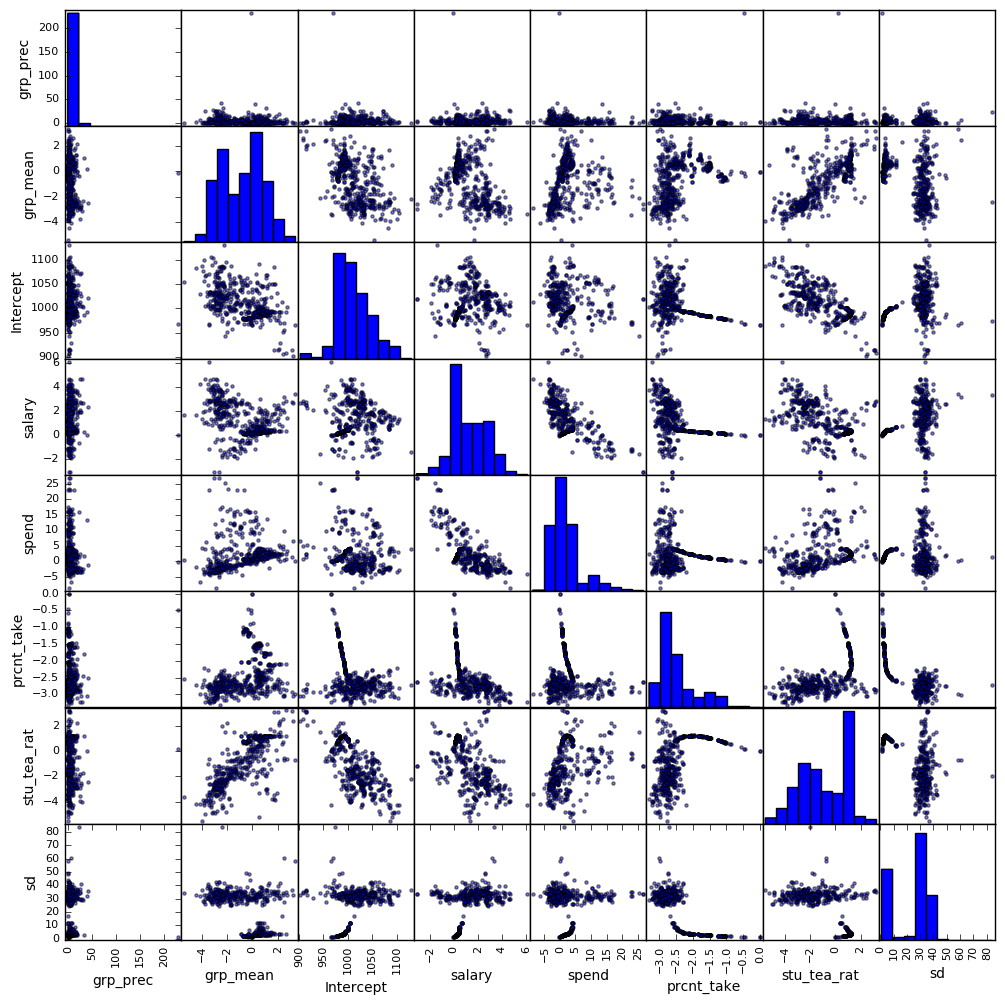

In [12]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [13]:
tdf_gain = 5.
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1) #grp_df)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std())
    glm.glm('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
                intercept_prior=intercept, regressor_prior=slope)

    trace_sat = sample(2000, NUTS())

Applied log-transform to grp_prec and added transformed grp_prec_log_ to model.
Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [14:45<00:00,  2.26it/s]


# Logistic Regression

In [14]:
htwt_data = pd.read_csv('../data/HtWt.csv')
htwt_data.head()

male  height  weight
0     0    63.2   168.7
1     0    68.7   169.8
2     0    64.8   176.6
3     0    67.9   246.8
4     1    68.9   151.6

In [15]:
m = glm_sm('male ~ height + weight', htwt_data, family=sm.families.Binomial()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   male   No. Observations:                   70
Model:                            GLM   Df Residuals:                       67
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -28.298
Date:                Thu, 13 Oct 2016   Deviance:                       56.597
Time:                        10:09:12   Pearson chi2:                     62.8
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -45.2059     10.887     -4.152      0.000       -66.545   -23.867
height         0.6571      0.164      4.018      0.0

In [16]:
with Model() as model_htwt:
    glm.glm('male ~ height + weight', htwt_data, family=glm.families.Binomial())
    trace_htwt = sample(1000, NUTS())

Applied logodds-transform to p and added transformed p_logodds_ to model.
INFO:pymc3:Applied logodds-transform to p and added transformed p_logodds_ to model.
100%|██████████| 1000/1000 [00:04<00:00, 209.06it/s]


                mean        std         min        25%        50%        75%  \
Intercept -50.709383  13.193083 -103.853682 -60.323900 -51.081365 -42.115205   
height      0.734066   0.198251    0.001119   0.610875   0.734487   0.874961   
weight      0.012040   0.011574   -0.019890   0.003990   0.011760   0.019576   
p           0.501184   0.285154    0.000300   0.261417   0.497641   0.738970   

                max  
Intercept -0.089848  
height     1.530992  
weight     0.045454  
p          0.998552  
P(weight < 0) =  0.146
P(height < 0) =  0.0


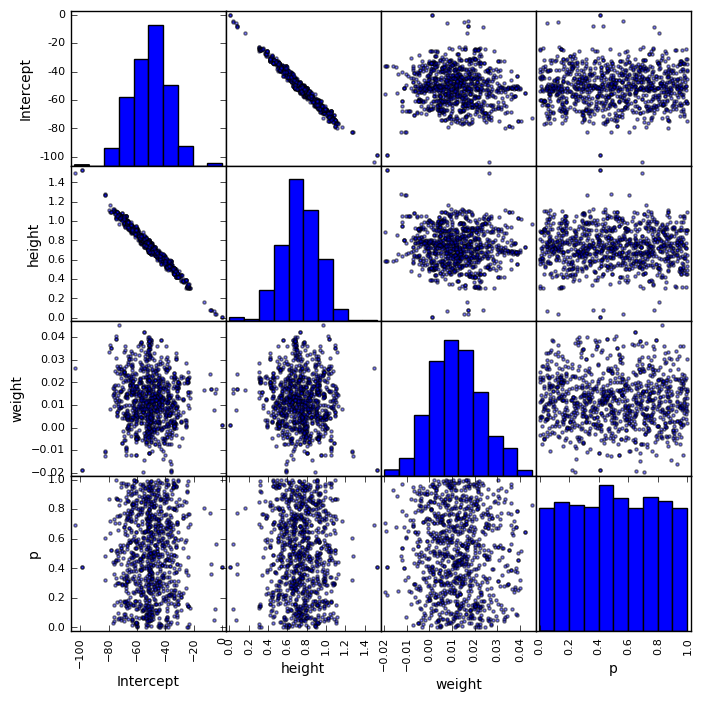

In [17]:
trace_df = trace_to_dataframe(trace_htwt)
print(trace_df.describe().drop('count').T)
scatter_matrix(trace_df, figsize=(8, 8))
print("P(weight < 0) = ", (trace_df['weight'] < 0).mean())
print("P(height < 0) = ", (trace_df['height'] < 0).mean())

## Bayesian Logistic Lasso

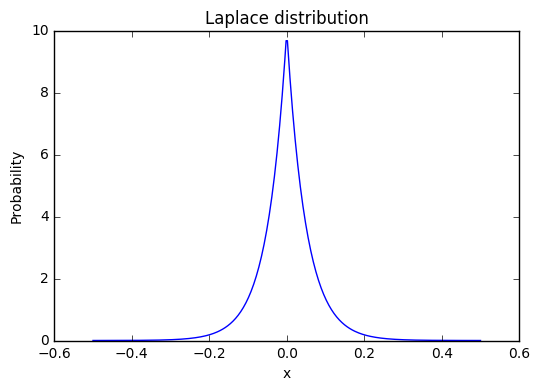

In [18]:
lp = Laplace.dist(mu=0, b=0.05)
x_eval = np.linspace(-.5, .5, 300)
plt.plot(x_eval, theano.tensor.exp(lp.logp(x_eval)).eval())
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Laplace distribution');

Applied logodds-transform to p and added transformed p_logodds_ to model.
INFO:pymc3:Applied logodds-transform to p and added transformed p_logodds_ to model.
100%|██████████| 500/500 [00:02<00:00, 207.93it/s]


                mean       std        min        25%        50%        75%  \
Intercept -24.586548  7.999507 -43.240430 -30.782016 -23.721298 -19.595319   
height      0.341485  0.124828  -0.006850   0.261879   0.331836   0.432426   
weight      0.012132  0.008559  -0.011290   0.006719   0.011425   0.017528   
p           0.490834  0.289292   0.008668   0.229746   0.476395   0.731364   

                max  
Intercept  0.375426  
height     0.619124  
weight     0.038408  
p          0.999594  


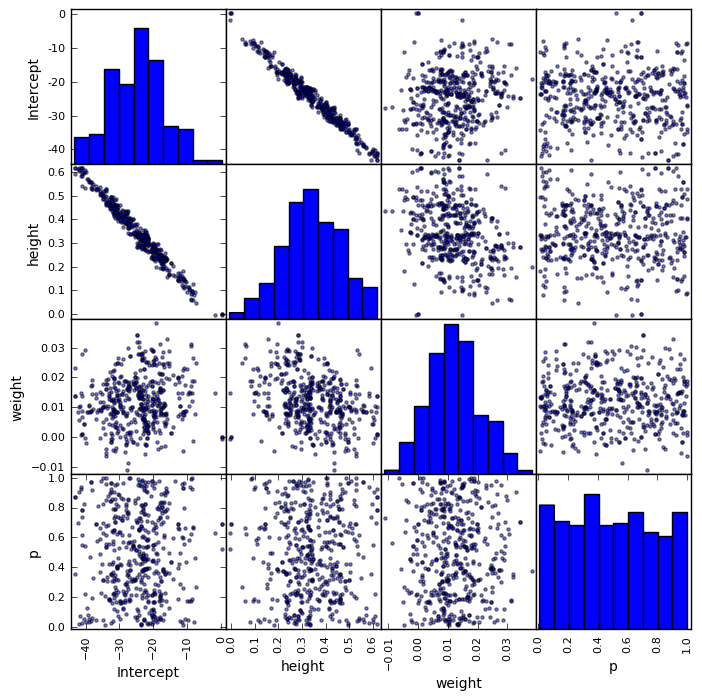

In [19]:
with Model() as model_lasso:
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=0, sd=50),
              'height': Laplace.dist(mu=0, b=0.05),
              'weight': Laplace.dist(mu=0, b=0.05)
    }
    glm.glm('male ~ height + weight', htwt_data, family=glm.families.Binomial(),
                    priors=priors)
    
    trace_lasso = sample(500, NUTS())
    
trace_df = trace_to_dataframe(trace_lasso)
scatter_matrix(trace_df, figsize=(8, 8));
print(trace_df.describe().drop('count').T)